In [128]:
import numpy as np
from scipy.integrate import solve_ivp

# Define constants
mFe56 = 55.9349375  # Mass of Fe-56 in atomic mass units
mFe56A = 56.0
mn = 1.00866491578  # Neutron mass in atomic mass units
# Convert atomic mass units to energy (MeV)
uUnit = 931.5  # MeV
hbarc = 197.3  # MeV*fm
# Reduced mass
mc = mFe56 * mn / (mFe56 + mn)
mcMeV = mc * uUnit
# Constant c1
c1 = 2 * mcMeV / hbarc**2
a0 = 1  # fm
r0 = 1  # fm
EinLab = 10  # MeV
Eincm = EinLab * mFe56 / (mFe56 + mn)
# Define nuclear potential parameters
R0 = r0 * mFe56A**(1/3)  # Nuclear radius
V0 = 1  # Potential depth in MeV
def woods_saxon_potential(V0, R, a, r):
    return V0 / (1 + np.exp((r - R) / a))
# Define the potential function for Fe-56
def VFe56n(r):
    return woods_saxon_potential(V0, R0, a0, r)
# Energy of channel in center of mass frame
Ec = Eincm
# Matching radius
matchRad = R0 + a0 * np.log(10**6 * V0 / Eincm)
# Wave number kc
kc = np.sqrt(c1 * Ec)
# l = Angular momentum quantum number
def schrodinger_eq(r, u,l):
    return c1 * u * (-Ec + (l * (l + 1)) / (c1 * r**2) - VFe56n(r))

def differential_equation(r, y,l):
    u, up = y
    return [up, schrodinger_eq(r, u,l)]

def solve_schrodinger(l):
    start = 0.001
    end = matchRad*1.1
    meshN = int(matchRad / start)
    r_vals = np.linspace(start, end, meshN)
    y0 = [0, 1]  # Boundary conditions: u(0) = 0, u'(0) = 1
    sol = solve_ivp(differential_equation, [start, end], y0, t_eval=r_vals, args=(l,) , method = "Radau")
    return sol

# Compute \beta(r)
def beta(r, l):
    sol = solve_schrodinger(l)
    u_interp = np.interp(r, sol.t, sol.y[0])
    up_interp = np.interp(r, sol.t, sol.y[1])
    return r * up_interp / u_interp if u_interp != 0 else np.nan

print("Constants:")
print(f"c1 = {c1:.6f} MeV/fm^2")
print(f"Eincm = {Eincm:.6f} MeV")
print(f"Match radius = {matchRad:.6f} fm")
print(f"kc = {kc:.6f} fm^-1")

# Evaluate and print beta at the matching radius
beta_matchRad = beta(matchRad, l=0)
print(f"Beta at matching radius ({matchRad:.6f} fm): {beta_matchRad:.6f}")


Constants:
c1 = 0.047418 MeV/fm^2
Eincm = 9.822866 MeV
Match radius = 15.356660 fm
kc = 0.682482 fm^-1
Beta at matching radius (15.356660 fm): 4.222267


In [129]:
sol = solve_schrodinger(0)
np.interp(matchRad, sol.t, sol.y[0])

np.float64(-1.3294131694645315)

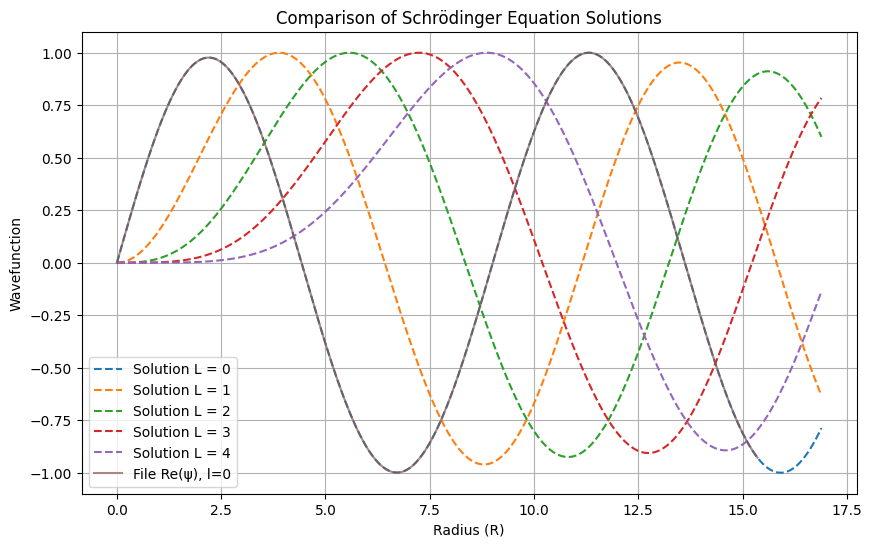

In [130]:
# Plot solutions for myl = 0, 1, 2, 3, 4
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

for l in range(5):
    sol = solve_schrodinger(l)
    plt.plot(sol.t, sol.y[0] / sol.y[0].max(), linestyle="--", label=f'Solution L = {l}' )

# Load and plot data from files
for l in range(1):
    data = np.loadtxt(f"intwavefunction_l_{l}.dat")
    R, Re_psi, Im_psi, Abs_psi = data.T
    plt.plot(R, Re_psi / Re_psi.max(), label=f"File Re(ψ), l={l}", alpha  = 0.7)

plt.xlabel("Radius (R)")
plt.ylabel("Wavefunction")
plt.title("Comparison of Schrödinger Equation Solutions")
plt.legend()
plt.grid()
plt.show()

In [131]:
matchRad

np.float64(15.35665999230729)

In [132]:
R[15356], Re_psi[15356] / Re_psi.max()

(np.float64(15.356), np.float64(-0.927107601735467))

In [133]:
from scipy.special import spherical_jn, spherical_yn

def spherical_hankel1(n, x):
    """Computes the spherical Hankel function of the first kind."""
    return spherical_jn(n, x) + 1j * spherical_yn(n, x)

def spherical_hankel2(n, x):
    """Computes the spherical Hankel function of the second kind."""
    return spherical_jn(n, x) - 1j * spherical_yn(n, x)

def spherical_hankel1_derivative(n, x):
    """Computes the derivative of the spherical Hankel function of the first kind."""
    return spherical_jn(n, x, derivative=True) + 1j * spherical_yn(n, x, derivative=True)

def spherical_hankel2_derivative(n, x):
    """Computes the derivative of the spherical Hankel function of the second kind."""
    return spherical_jn(n, x, derivative=True) - 1j * spherical_yn(n, x, derivative=True)

def Ifunc(r, kc, l):
    """Computes I function."""
    return -1j * kc * r * spherical_hankel2(l, kc * r)

def Ofunc(r, kc, l):
    """Computes O function."""
    return 1j * kc * r * spherical_hankel1(l, kc * r)

def Ifunc_derivative(r, kc, l):
    """Computes the derivative of I function."""
    hankel2_deriv = spherical_hankel2_derivative(l, kc * r)
    return -1j * kc * (spherical_hankel2(l, kc * r) + kc * r * hankel2_deriv)

def Ofunc_derivative(r, kc, l):
    """Computes the derivative of O function."""
    hankel1_deriv = spherical_hankel1_derivative(l, kc * r)
    return 1j * kc * (spherical_hankel1(l, kc * r) + kc * r * hankel1_deriv)



def Ufunc(r,l):
    """Computes U function."""
    numerator = beta(r,l) * Ifunc(r, kc, l) -  r * Ifunc_derivative(r, kc, l)
    denominator = beta(r,l) * Ofunc(r, kc, l) -  r * Ofunc_derivative(r, kc, l)
    return numerator / denominator

In [134]:
Ufunc(matchRad, l=0)

np.complex128(0.9653736188333601+0.2608711867197718j)

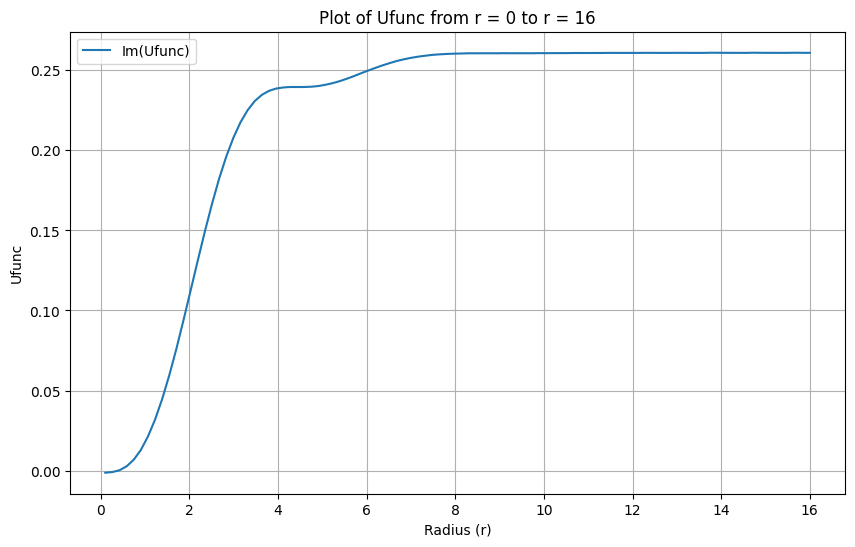

In [135]:
r_values = np.linspace(0.1, 16, 100)
U_values = [Ufunc(r, l=0) for r in r_values]

plt.figure(figsize=(10, 6))
#plt.plot(r_values, np.real(U_values), label='Re(Ufunc)')
plt.plot(r_values, np.imag(U_values), label='Im(Ufunc)')
#plt.plot(r_values, np.abs(U_values), label='abs(Ufunc)')
#plt.plot(r_values, np.abs(1-np.array(U_values)), label='abs(1-U)')
plt.xlabel('Radius (r)')
plt.ylabel('Ufunc')
plt.title('Plot of Ufunc from r = 0 to r = 16')
plt.legend()
plt.grid()
plt.show()

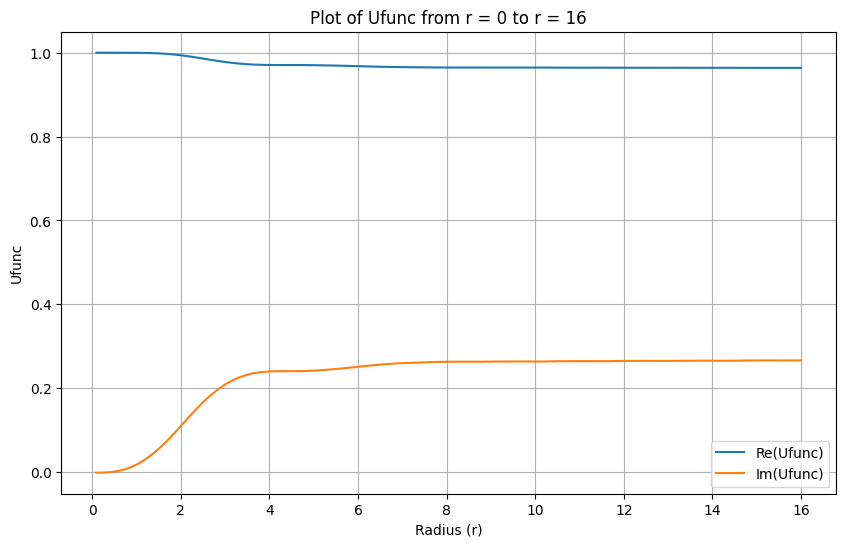

In [63]:
Ufunc(matchRad, l=1)

np.complex128(0.9757195135408785+0.21902381353531306j)

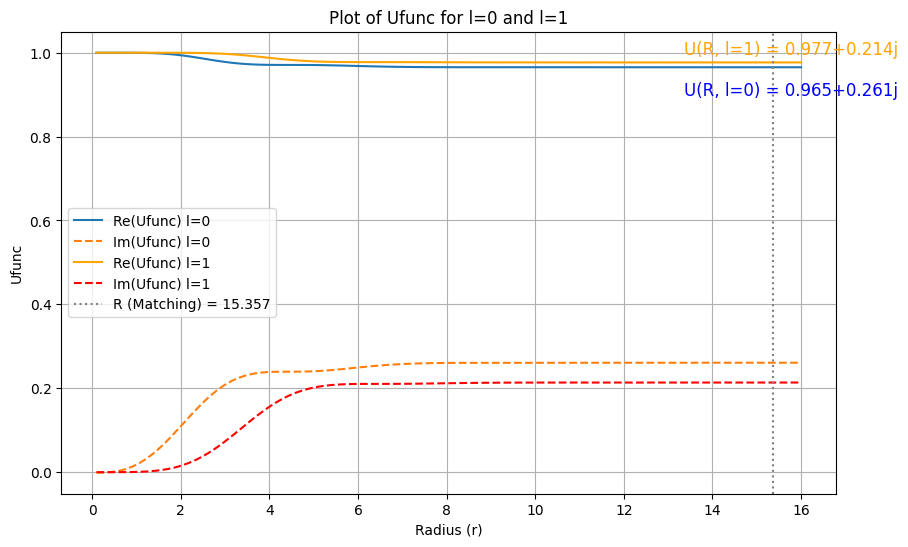

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Define your function (assuming Ufunc is already defined)
r_values = np.linspace(0.1, 16, 100)

# Compute U(r) for l=0 and l=1
U_values_l0 = np.array([Ufunc(r, l=0) for r in r_values])
U_values_l1 = np.array([Ufunc(r, l=1) for r in r_values])

# Find U(7) for both l=0 and l=1
r_target = matchRad
U_target_l0 = Ufunc(r_target, l=0)
U_target_l1 = Ufunc(r_target, l=1)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(r_values, np.real(U_values_l0), label='Re(Ufunc) l=0', linestyle='solid')
plt.plot(r_values, np.imag(U_values_l0), label='Im(Ufunc) l=0', linestyle='dashed')
plt.plot(r_values, np.real(U_values_l1), label='Re(Ufunc) l=1', linestyle='solid', color='orange')
plt.plot(r_values, np.imag(U_values_l1), label='Im(Ufunc) l=1', linestyle='dashed', color='red')

# Add vertical line at x=7
plt.axvline(x=r_target, color='gray', linestyle='dotted', label=f'R (Matching) = {r_target:.3f}')

# Annotate the value of U at x=7
plt.text(r_target -2, np.real(U_target_l0)*0.93, f'U(R, l=0) = {U_target_l0:.3f}', fontsize=12, color='blue')
plt.text(r_target -2, np.real(U_target_l1)*1.02, f'U(R, l=1) = {U_target_l1:.3f}', fontsize=12, color='orange')

# Labels and title
plt.xlabel('Radius (r)')
plt.ylabel('Ufunc')
plt.title('Plot of Ufunc for l=0 and l=1')
plt.legend()
plt.grid()
plt.show()
